# Lab 7: Training neural networks (part 2)
**Like always, remember to set Runtime environment to GPU**

In this lab we will explore more tools that will help you train your own neural networks. This time we will be using convolutional neural networks (CNNs).


## 1. Download the CIFAR 10 dataset
We will be using the CIFAR 10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

mean = 0.5
std = 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean, mean, mean), (std, std, std))])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]


Display some stats

num_train 49984
num_test 9984
images.shape torch.Size([64, 3, 32, 32])


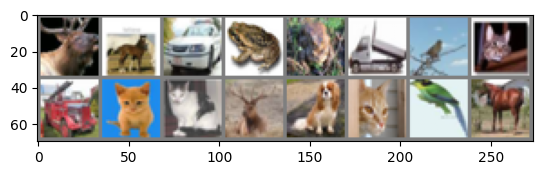

 deer horse   car  frog  frog truck  bird   cat truck   cat   cat  deer   dog   cat  bird horse


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy() / 2 + 0.5 # Un-normalize
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Number of samples
num_train = bs * len(trainloader)
num_test = bs * len(testloader)
print('num_train',num_train)
print('num_test',num_test)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('images.shape',images.shape)

# show 16 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## 2. Task 1 (optional): Setting up your CNN
**You can skip this task and jump directly to Task 2, if you feel comfortable with PyTorch and the different layer types used in CNNs.**

Here, we will set up our own CNN. For this purpose we will need the following layer types:

- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear])

as well as the reshape operation (called `view` in PyTorch):

- [view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view)

See complete overview of the basic building block for graphs [here](https://pytorch.org/docs/stable/nn.html).

Let's see how each of these work:

In [3]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

**Side-note:** What's the difference between torch.nn and torch.nn.functional? Read [here](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597/7)

### 2.1 Conv2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

In [4]:
# Print shape of input
print('Input dimensions are (batch_size, channels, height, width)')
print('images.shape',images.shape)

# Perform convolution
conv = nn.Conv2d(3, 6, 5)
x = conv(images)

# Print shape of output
print('x.shape',x.shape)

# Print parameter shapes
for name, param in conv.named_parameters(): print('parameter',name,param.shape)

Input dimensions are (batch_size, channels, height, width)
images.shape torch.Size([64, 3, 32, 32])
x.shape torch.Size([64, 6, 28, 28])
parameter weight torch.Size([6, 3, 5, 5])
parameter bias torch.Size([6])


#### 2.1.1 Questions
1. What do each of the parameters (3, 6, 5) mean?
2. Recall the formula to calculate the output size of a convolution:

 `output_size = (input_size - kernel_size) / stride + 1`

 or as defined in the slides of Lecture 4:

 `output_size = (N - W) / stride + 1`

 Is this formula satisfied in the above example?

3. How could you make the output (x) have the same width and height as
the input (images)? (Think "padding"...)

4. If the convolution operation performed above was a layer in a CNN, what would the number of parameters of that layer be?

#### 2.1.2 Answers
1. `(in_channels, out_channels, kernel_size) = (3, 6, 5)`, where `in_channels` is the number of channels of the input (3 here because input is a color image), `out_channels` is the number of feature meaps that will be generated, and `kernel_size` is the filter size. It is common practise to use the names of the arguments, like this:

 `conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)`

2. Yes. We have `N = input_size = 32`, `W = kernel_size = 5`, `stride = 1` (default), so theoretically `output_size = (32-5)/1 + 1 = 28`, which matches the shape of `x`.

3. `Conv2d` has a padding option. By setting `padding = 2`, the output gets the same width/height as the input (see code below). The formula for calculating the right padding size is (see slides from lecture 5): `padding = (W-1)/2 = (5-1)/4 = 2`.

4. For the filter weights the number of parameters is `out_channels * in_channels * kernel_size^2 = 6 * 3 * 5 * 5 = 450`. In addition there is one bias parameters for each output, totalling `450 + 6 = 456` parameters.

In [6]:
# Code for question 2: Padding
conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
x = conv(images)

# Width and height are the same
print('x.shape',x.shape)
print('images.shape',images.shape)

x.shape torch.Size([64, 6, 32, 32])
images.shape torch.Size([64, 3, 32, 32])


### 2.2 MaxPool2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d

In [7]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

# Perform max pool
pool = nn.MaxPool2d(2, 2)
y = pool(x)
print('y.shape',y.shape)

# Print some elements
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])
print('y[0,0,0:2,0:2]:\n',y[0,0,0:2,0:2])

y.shape torch.Size([64, 6, 14, 14])
x[0,0,0:4,0:4]:
 tensor([[-0.9663, -0.3148, -0.9152, -0.3116],
        [ 0.2697, -1.8497,  1.9567,  1.3909],
        [ 1.1925,  0.0394, -1.8230,  0.8007],
        [-1.2329, -0.1553,  1.3594, -0.1415]])
y[0,0,0:2,0:2]:
 tensor([[0.2697, 1.9567],
        [1.1925, 1.3594]])


#### 2.2.1 Questions
1. What does MaxPool2d do? (Explain the output `y[0,0,0:2,0:2]` and compare to `x[0,0,0:2,0:2]`)

2. What do each of the parameters (2, 2) mean?

#### 2.2.2 Answers
1. It downscales the input along the widht and height dimensions. It does so by running a "window" over the input. For each window it outputs the maximum value within the window. In the example above, the window size is 2x2, and the window is shifted to pixels. Hence, the output `y` is half the width/height of the input `x`, and the output values are the maxima of the corresponding window of the input.
2. The first parameter is the window size (or kernel_size), and the second parameter is the stride (i.e., how many pixel the window position is shifted).

### 2.3 BatchNorm2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d

In [8]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)*10 + 2
print('x.mean',x.mean())
print('x.std',x.std())

# Perform batch normalization
bn = nn.BatchNorm2d(6)
y = bn(x)
print('y.mean',y.mean())
print('y.std',y.std())

# Print parameter shapes
for name, param in bn.named_parameters(): print('parameter',name,param.shape)

x.mean tensor(1.9683)
x.std tensor(10.0164)
y.mean tensor(-9.3766e-10, grad_fn=<MeanBackward0>)
y.std tensor(1.0000, grad_fn=<StdBackward0>)
parameter weight torch.Size([6])
parameter bias torch.Size([6])


#### 2.3.1 Questions
1. What does BacthNorm2D do?

2. What does the input parameter (6) mean?

3. Is the mean and standard deviation after batch normalization as expected?

4. How many parameters does BatchNorm2D have? Why?

#### 2.3.2 Answers
1. For each batch, it normalizes the values of the input according to the equation found in the documentation (and slides of lecture 6). The normalization is based on a standard score `y=(x-mean(x))/std(x)`, with the addition of two *learnable* parameters that can revert the standard score to produce the identity function if necessary. So the final equation becomes `y = gamma*(x-mean(x))/std(x) + beta` and with `gamma=std(x)` and `beta=mean(x)`, we get the identity function `y=x`. The initial values of the parameters are `gamma=1` and `beta=0`.

2. It is `num_features` corresponding to `C` with an expected input of size `(N, C, H, W)`.

3. The mean and standard deviation of output `y` should be 0 and 1, respectively. That seems to be the case.

4. It has 2x6: a gamma and a beta for each input channel.

### 2.4 ReLU
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

In [9]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)
print('x.min',x.min())
print('x.max',x.max())
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])

# Apply ReLU
y = F.relu(x)
print('y.min',y.min())
print('y.max',y.max())
print('y[0,0,0:4,0:4]:\n',y[0,0,0:4,0:4])

x.min tensor(-4.5226)
x.max tensor(4.3266)
x[0,0,0:4,0:4]:
 tensor([[ 0.1641, -0.5672, -0.8536, -0.0677],
        [ 0.6211, -1.2033,  0.7594, -0.5664],
        [-0.4447, -0.9073, -0.3646, -0.5684],
        [ 0.2039, -0.3097,  0.5767,  1.1741]])
y.min tensor(0.)
y.max tensor(4.3266)
y[0,0,0:4,0:4]:
 tensor([[0.1641, 0.0000, 0.0000, 0.0000],
        [0.6211, 0.0000, 0.7594, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.2039, 0.0000, 0.5767, 1.1741]])


#### 2.4.1 Question
1. What does ReLU do? (Explain the output `y[0,0,0:4,0:4]` and compare to `x[0,0,0:4,0:4]`)

#### 2.4.2 Answers
1. It sets all negative values to zero. That's it.

### 2.5 Linear and view
Reference to documentation:
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view

Recall that CNNs for classification are divided into two blocks:

1. **Convolutional base (encoder):** A sequence of convolutional layers resulting in a feature map that you may think of as a multi-dimensional image with a certain width, height, and depth (number of channels).

2. **Fully connected layers (decoder):** One or more fully connected layers ending with a classifier.

The input to the decoder has to be a vector with the correct dimensions. Thus, our task is to convert the feature map into a vector. In the code below we wish to take the feature map `x`, vectorize it, and feed it through a fully connected layer to produce 10-dimensional output.

Your task is to figure out, what value `N` should have (see helper questions below):

In [10]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

N = 6*28*28 # Solution

# Vectorize
y = x.view(-1, N)
print('y.shape',y.shape)

# Fully connected layer
fc = nn.Linear(N,10)
z = fc(y)
print('z.shape',z.shape)

y.shape torch.Size([64, 4704])
z.shape torch.Size([64, 10])


The correct output shape (of z) is [64, 10], where 64 is the batch size and 10 is the dimensionality we want in the output side of the fully connected layer.

#### 2.5.1 Helper questions
1. What does `view` do?

2. What does `Linear` do?


#### 2.5.2 Answers
1. `view` returns a new tensor with the same data as the input tensor but of a different shape. Our input has shape `(64,6,28,28)`, where the dimensions are `(batch_size, channels, height, width)`. When vectorizing this, we want to keep the batch dimensions, so the output should have size `(64,6*28*28)`, so `N = 6*28*28 (= 4704)`.

2. `Linear` applies a linear transformation to the incoming data: `y = Wx + b`, where `x` has shape `(batch_size, in_features)`, and the output has shape `(batch_size, out_features)`. Therefore, the parameters of `Linear` are `(in_features, out_features)`. Here we have `in_features = N = 6*28*28`.


## 2.6 Dropout
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout

Dropout is normally used only in relation to fully connected layers (i.e., not convolutional layers). The example below demonstrates the effect of the Dropout layer:

In [11]:
# Random input - dimensions are (batch_size, num_in_features)
x = torch.randn(64,10)
print('x[0,:]',x[0,:])

drop = nn.Dropout(p=0.5)
y = drop(x)
print('y[0,:]',y[0,:])

print('ratios',y[0,:]/x[0,:])

x[0,:] tensor([ 0.8241,  1.8991, -0.3548, -0.5416,  1.0800, -0.1697, -1.5941,  0.1006,
         1.7588,  0.0437])
y[0,:] tensor([ 0.0000,  3.7981, -0.7097, -1.0831,  2.1600, -0.3395, -0.0000,  0.2012,
         0.0000,  0.0000])
ratios tensor([0., 2., 2., 2., 2., 2., 0., 2., 0., 0.])


**IMPORTANT NOTE:** If necessary, re-run the code block until the printed part of `y[0,:]` contains both zeros and non-zeroes.

#### 2.6.1 Questions
1. Explain why there are zeroes in `y`.

2. Ratios: Why are the values of the non-zero entries of `y` twice as large as the corresponding values of the input `x`?

3. What happens to the ratios if you set `p=0.75`?

#### 2.6.2 Answers
1. Applying Dropout has the affect of setting elements to zero with a certain probability `p`. In other words the output `y` will be identical to input `x`, except that a fraction `p` of the elements (roughly) are set to zero.

2. When using Dropout in the context of a neural network, we apply Dropout only during training, but not during testing/evaluation. So if `p=0.5` half of the neurons will be inactive during training, but not during testing. To compensate for this, we can scale the output `y` by `1/(1-p)` during training. In this example `1/(1-p) = 1/0.5 = 2`, so the non-zero elements of `y` are twice is large as the corresponding elements of input `x`.

3. The ratios become `4` instead of `2`(see code below) because `1/(1-0.75) = 1/0.25 = 4`.

In [12]:
# Setting p = 0.75, the ratio becomes 4
drop = nn.Dropout(p=0.75)
y = drop(x)
print('ratios',y[0,:]/x[0,:])

ratios tensor([0., 0., 0., 0., 0., 4., 0., 0., 0., 0.])


## 2.7 Setting up the model
Your task is to fill in the blanks (???) below.

Hint: You can insert print statements in the `forward` function, which is executed when calling `scores = model(images)`.

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 16 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        self.fc2 = nn.Linear(in_features=120, out_features=10) # in_features = 120 because out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16*5*5) # 16*5*5 because input shape is 16 x 5 x 5
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): print('parameter',name,param.shape)

# Test model
scores = model(images)
print(scores.shape)

Network architecture:

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
Network parameters:

parameter conv1.weight torch.Size([6, 3, 5, 5])
parameter conv1.bias torch.Size([6])
parameter bn1.weight torch.Size([6])
parameter bn1.bias torch.Size([6])
parameter conv2.weight torch.Size([16, 6, 5, 5])
parameter conv2.bias torch.Size([16])
parameter bn2.weight torch.Size([16])
parameter bn2.bias torch.Size([16])
parameter fc1.weight torch.Size([120, 400])
parameter fc1.bias torch.Size([120])
parame

Example code to find shape of input to first fully connected layer:

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 16 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        #self.fc1 = nn.Linear(in_features=???, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        #self.fc2 = nn.Linear(in_features=???, out_features=10) # in_features = 120 becuase out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        print(x.shape)
        #x = x.view(-1, ???)
        #x = self.drop(x)
        #x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)
        return x

model = Net()

# Test model
x = model(images)
print(x.shape)

torch.Size([64, 16, 5, 5])
torch.Size([64, 16, 5, 5])


## 3. Task 2: Training the model
In this task, just run the code, observe what happens and do your best to understand it.

In [15]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

### 3.1 Setting up the CNN model
First, lets set up a simple CNN with 2 convolutional layers, followed by two fully connected layers. The network is equivalent to the network defined above in Task 1. Each convolution operation is followed by batch normalization, ReLU, and max pooling (Note that instead of max pooling we could also have applied convolution with a stride of 2 to achieve the same level of down-sizing). The flatten layer reshapes the output of the last conv layer to a vector. We perform dropout on this vector with p = 0.5, before applying the two fully connected layers.

In [16]:
def Net():
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(), # vectorize
      nn.Dropout(p=0.5),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

model = Net()

print('Network parameters:\n')
print(model)

# Print parameter shapes
for name, param in model.named_parameters(): print('parameter',name,param.shape)

Network parameters:

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=400, out_features=120, bias=True)
  (11): ReLU()
  (12): Linear(in_features=120, out_features=10, bias=True)
)
parameter 0.weight torch.Size([6, 3, 5, 5])
parameter 0.bias torch.Size([6])
parameter 1.weight torch.Size([6])
parameter 1.bias torch.Size([6])
parameter 4.weight torch.Size([16, 6, 5, 5])
parameter 4.bias torch.Size([16])
parameter 5.weight torch.Size([16])
parameter 5.bias

Here is a useful function that you can call to re-initialize the weights/parameters of the model:

In [17]:
def reset_parameters(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1) # Why 1? Gamma = scaling = 1
            torch.nn.init.constant_(m.bias, 0) # Why 0? Beta = offset = 0
        elif isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

reset_parameters(model)

### 3.2 Testing the model
Let's test the model:

In [18]:
# Move data to GPU
images = images.cuda()
labels = labels.cuda()

# Calculate scores
model = Net().cuda()
scores = model(images)  # predictions

print(scores.shape)

torch.Size([64, 10])


### 3.3 Calculating the accuracy
The scores (logits) don't have any meaningful interpretation, but we can convert them into class probabilities using softmax. Since we are only going to be interested in the model's accuracy, we will wrap the softmax inside function accuracy that calculates the accuracy on a batch:

In [19]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

Accuracy tensor(0.1562, device='cuda:0')


### 3.4 Calculating the loss
I order to train your model, we also need a loss function. We will use the cross entropy loss already provided in PyTorch:

In [20]:
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

Loss tensor(2.3469, device='cuda:0', grad_fn=<NllLossBackward0>)


### 3.5 Training function (fit)
The code below can be used to train a model and monitor important stats as training progresses. The training is carried out by calling the `fit` function, which takes any model as input.

You can change the optimizer by replacing `base_optimizer` with your own function handle.

The function `base_lr_scheduler` is a learning rate scheduler that updates the learning rate of the optimizer during training. The dummy-implementation does nothing, but you can modify it to implement your own learning rate scheduler. The inputs are
- `T` : Total number of batches
- `t` : Current batch index (max(t) = T)
- `lr` : Current learning rate

Other parameters to `fit` are:
- `bs` the batch size
- `epochs` the number of epochs
- `batches_per_epoch` the number of batches per epoch. If set to `None`, all images in the dataset are used.

Note that you can use `batches_per_epoch` to reduce the size of the training set. The effective size of the training set is `bs*batches_per_epoch`.

In [21]:
from torch import optim

# Function handle that returns an optimizer
def base_optimizer(model,lr=0.001, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr,momentum=momentum)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def base_lr_scheduler(t,T,lr):
  return lr

# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  # Initialize optimizer
  opt = opt_func(model)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss.detach().cpu().numpy())
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      pred = model(xb.cuda())
      loss = loss_func(pred, yb.cuda())

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

      # Validation loss and accuracy
      if t % 10 == 0:    # print every 10 mini-batches
        model.eval() # Test mode
        with torch.no_grad():
            valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss_history.append(valid_loss.detach().cpu().numpy())
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        model.train() # Back to train mode

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    print(valid_loss_history)
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history

### 3.6 Train the model
Train the model and inspect the loss curves.

Epochs: 1 Batches per epoch: 196 Total number of batches 196
t 10 lr 0.001 train loss 3.4442356 val loss 2.5776699 val accuracy 0.098242186
t 20 lr 0.001 train loss 3.030522 val loss 2.438724 val accuracy 0.120507814
t 30 lr 0.001 train loss 2.7565935 val loss 2.3590913 val accuracy 0.14882813
t 40 lr 0.001 train loss 2.6686316 val loss 2.267686 val accuracy 0.17548828
t 50 lr 0.001 train loss 2.498907 val loss 2.196264 val accuracy 0.19707032
t 60 lr 0.001 train loss 2.61693 val loss 2.145952 val accuracy 0.2154297
t 70 lr 0.001 train loss 2.4150028 val loss 2.112137 val accuracy 0.23242188
t 80 lr 0.001 train loss 2.4650078 val loss 2.0824387 val accuracy 0.24736328
t 90 lr 0.001 train loss 2.3281708 val loss 2.0613084 val accuracy 0.25322267
t 100 lr 0.001 train loss 2.2894285 val loss 2.0435548 val accuracy 0.26250002
t 110 lr 0.001 train loss 2.376508 val loss 2.0288866 val accuracy 0.26816407
t 120 lr 0.001 train loss 2.2004867 val loss 2.0176878 val accuracy 0.2692383
t 130 lr 0

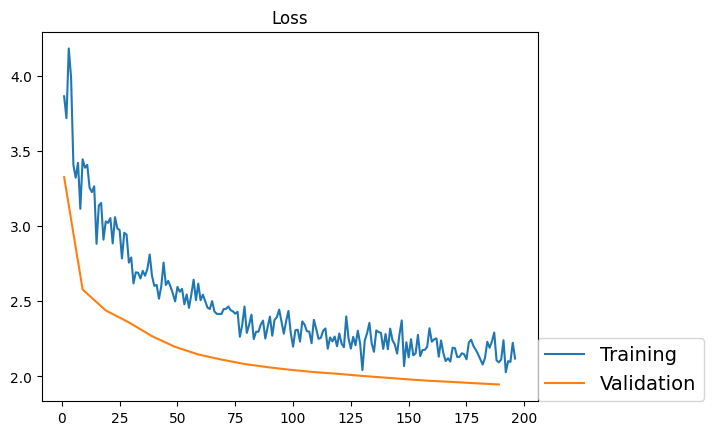

In [22]:
# Re-initialize weights
reset_parameters(model)

# Train with defaul settings.
train_loss_history = fit(model)

**Note:** The validation loss (on the unseen data) is overall *lower* than the training loss. This might initially seem like an unexpected behaviour, but it results from the fact that we use 50% Dropout during training, meaning that half of the weights of the fully connected layers are not used during training. When evaluating the model on the validation set, Dropout is disabled, and all weights are used. This leads to a better prediction (i.e., a lower loss) on the validation set.

### 3.7 Performing quick experiments on reduced dataset
When searching for hyperparameters it is often useful to perform quick experiments on only a small subset of the data. You can do this by decreasing the batch size and setting `batches_per_epoch` to say 20. The effective size of the training set is then `bs*batches_per_epoch` (say `128*20 = 2,560`), and the total number of batches being processed during training is `bs*batches_per_epoch*epochs` (say `128*20*5 = 51,200`).


Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.223271 val loss 2.5859787 val accuracy 0.104687504
t 20 lr 0.001 train loss 2.8232028 val loss 2.4503648 val accuracy 0.1328125
t 30 lr 0.001 train loss 2.6571364 val loss 2.3742628 val accuracy 0.134375
t 40 lr 0.001 train loss 2.8114243 val loss 2.3141844 val accuracy 0.13906251
t 50 lr 0.001 train loss 2.662685 val loss 2.2674723 val accuracy 0.1515625
t 60 lr 0.001 train loss 2.4341817 val loss 2.216561 val accuracy 0.159375
t 70 lr 0.001 train loss 2.3980827 val loss 2.1744576 val accuracy 0.18125
t 80 lr 0.001 train loss 2.3717892 val loss 2.1494868 val accuracy 0.1875
t 90 lr 0.001 train loss 2.2656176 val loss 2.1264255 val accuracy 0.1875
t 100 lr 0.001 train loss 2.3670125 val loss 2.1034753 val accuracy 0.1921875
[array(3.389434, dtype=float32), array(2.5859787, dtype=float32), array(2.4503648, dtype=float32), array(2.3742628, dtype=float32), array(2.3141844, dtype=float32), array(2.267472

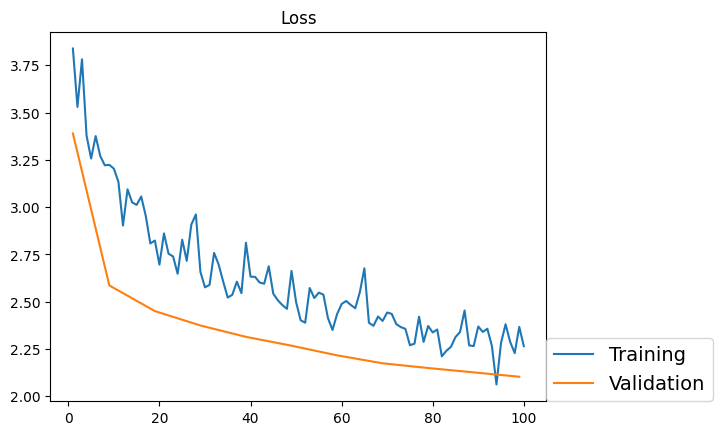

In [23]:
# Re-initialize weights
reset_parameters(model)

# Example: Train on small subset
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

### 3.7 Train with custom optimizer
Fell free to experiment with these optimizers.

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.1 train loss 2.217136 val loss 2.230211 val accuracy 0.1765625
t 20 lr 0.1 train loss 2.0144088 val loss 2.2434313 val accuracy 0.2203125
t 30 lr 0.1 train loss 2.09305 val loss 1.9470875 val accuracy 0.2953125
t 40 lr 0.1 train loss 1.805762 val loss 1.9118341 val accuracy 0.3
t 50 lr 0.1 train loss 2.043456 val loss 1.8661711 val accuracy 0.3140625
t 60 lr 0.1 train loss 1.8623688 val loss 1.8325809 val accuracy 0.3359375
t 70 lr 0.1 train loss 1.7493105 val loss 1.8293927 val accuracy 0.3265625
t 80 lr 0.1 train loss 1.6950223 val loss 1.7872177 val accuracy 0.3515625
t 90 lr 0.1 train loss 1.7831916 val loss 1.8842528 val accuracy 0.328125
t 100 lr 0.1 train loss 1.7966152 val loss 1.757802 val accuracy 0.346875
[array(4.21885, dtype=float32), array(2.230211, dtype=float32), array(2.2434313, dtype=float32), array(1.9470875, dtype=float32), array(1.9118341, dtype=float32), array(1.8661711, dtype=float32), array(1.

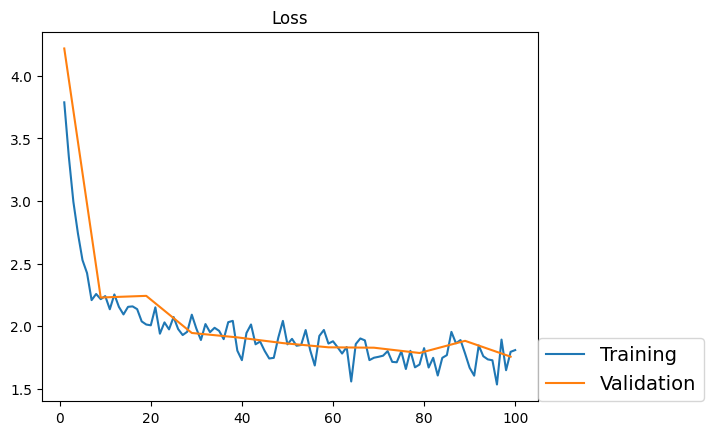

In [24]:
#SGD + Momentum
def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Adagrad
def adagrad_optimizer(model):
  return optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.0, weight_decay=0.0, initial_accumulator_value=0)

# RMSProp
def rmsprop_optimizer(model):
  return optim.RMSprop(model.parameters(), lr=0.1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# Adam
def adam_optimizer(model):
  return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Train with custom optimizer (on small subset)
reset_parameters(model) # Reset network weights
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

## 4. Tasks: You are free to choose any of the tasks below
The overall goal is to make the model perform as good as possible on the CIFAR 10 dataset. Solving the tasks below might help you, but feel free to try other options. For inspiration, here is a list of other things, you could do:

- **Increase the capacity of the network** (add more conv layers, add more kernels in each layer, add another fully connected layer, add more connections in the fully connected layer, etc.)
- **Experiment with weight decay** (weight decay is an option for, say, the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD))

General recommendations for hyperparameter search (see Lecture 6 slides):
- Stage your search from course to fine
- Start with a small sample (subset) of the dataset to tune in on hyperparameters such as learning rate, and start with 1 epoch or less
- The second stage could then perform a narrower search with more data and/or more epochs
- Search for learning rates in powers of 10. Good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4, etc.)
- **Look at loss curves!!!**


### 4.1 Implement a learning rate scheduler
**Your task** is to replace the function `base_lr_scheduler` with your own `step_decay` function (or another type of learning rate scheduler if you prefer). In step decay the lerning rate is updated for every `step` batches according to the rule `lr = lr * decay_rate`. The input `t` is the current batch index, ranging from 1 to `T`, where `T = batches_per_epoch * epochs` is the total number of batches.

**Solution:**

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.1 train loss 2.2095432 val loss 2.2784557 val accuracy 0.1796875
t 20 lr 0.09000000000000001 train loss 2.086629 val loss 2.0440245 val accuracy 0.25625
t 30 lr 0.08100000000000002 train loss 2.0282612 val loss 1.994735 val accuracy 0.2828125
t 40 lr 0.07290000000000002 train loss 2.0654366 val loss 1.9474934 val accuracy 0.315625
t 50 lr 0.06561000000000002 train loss 1.8997612 val loss 1.9349918 val accuracy 0.3078125
t 60 lr 0.05904900000000002 train loss 1.7889152 val loss 1.8894182 val accuracy 0.2953125
t 70 lr 0.05314410000000002 train loss 1.835218 val loss 1.8520058 val accuracy 0.3375
t 80 lr 0.04782969000000002 train loss 1.9611919 val loss 1.8557659 val accuracy 0.3390625
t 90 lr 0.043046721000000024 train loss 1.9635011 val loss 1.8395313 val accuracy 0.3140625
t 100 lr 0.03874204890000002 train loss 1.6481522 val loss 1.831395 val accuracy 0.334375
[array(3.3982542, dtype=float32), array(2.2784557, dtyp

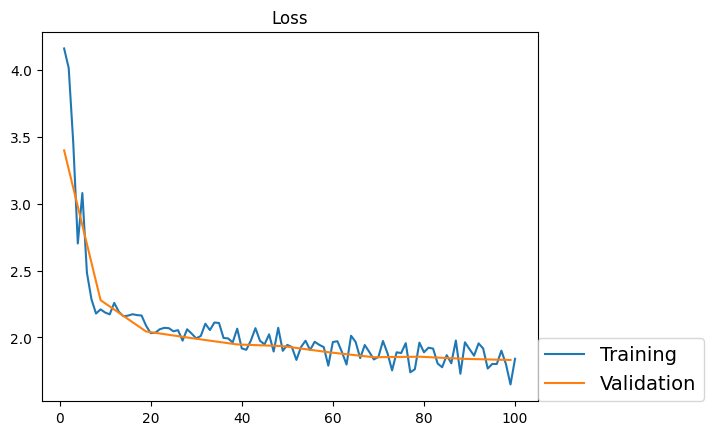

In [25]:
def step_decay(t,T,lr,step=10,decay_rate=0.9):
  if t % step == 0:
    lr = lr * decay_rate
  return lr

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,opt_func=momentum_optimizer,lr_scheduler=step_decay,bs=128,epochs=5,batches_per_epoch=20)

**Sub-tasks:**
- What new hyperparameters are added with learning rate decay?
- See if you can make the model perform better with learning rate decay.

**Comment/answer:**
- Two more hyperparameters are added: `step` and `decay_rate`

### 4.2 Implement a learning rate finder
Finding a good initial learning rate can be done efficiently with a learning rate finder. Here is the basic idea:

You can modify the learning rate scheduler `base_lr_scheduler` to use a hardcoded list of learning rates. This can be used to implement a learning rate finder according to this principle:
- Start training and increase learning rate linearly after each batch (!!!), and calculate the loss
- Then display the loss as a function of learning rate.
- By manual inspection, select a suitable range of learning rates by locating the strongest downward slope.

Say the hardcoded learning rates are:

In [34]:
# Ordered list of learning rates (ascending order)
lr_list = [0.001,0.01,0.05,0.1]

Then simply implement a learning rate scheduler that returns the t´th entry of the learning rate list:

In [35]:
def lr_finder(t,T,lr):
  return lr_list[t-1]

Note, the learning rate scheduler must have this interface: `(t,T,lr)`

Then train the model for as many batches as there are entries in the learning rate list:

In [36]:
# Make sure that we process as many batches as there are learning rates in our list:
batches_per_epoch = len(lr_list)
epochs = 1

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)

Epochs: 1 Batches per epoch: 4 Total number of batches 4


Plot the loss versus learning rate and inspect:

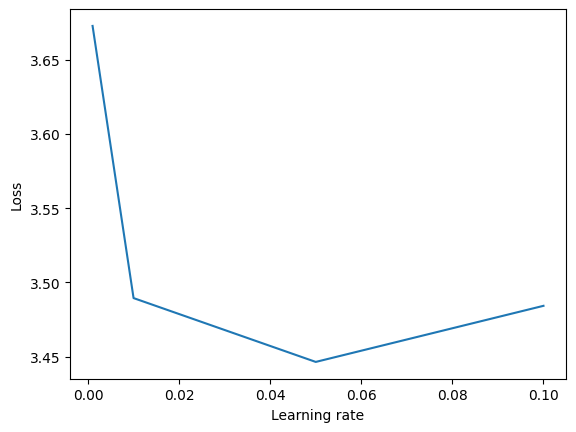

In [37]:
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xlabel('Learning rate');
plt.ylabel('Loss');

**Your task** is to implement a learning rate finder that searches through a range of learning rates, like above.

The range of learning rates should be logarithmic (say from 10^-6 to 10^0). You can define the list of learning rates using `np.logspace`.

Then plot the loss versus the learning rate. It is a good idea to use a logarithmic scale on the x-axis (see `plt.xscale('log')`).

#### 4.2.1 My solution

[1.00000000e-06 1.32571137e-06 1.75751062e-06 2.32995181e-06
 3.08884360e-06 4.09491506e-06 5.42867544e-06 7.19685673e-06
 9.54095476e-06 1.26485522e-05 1.67683294e-05 2.22299648e-05
 2.94705170e-05 3.90693994e-05 5.17947468e-05 6.86648845e-05
 9.10298178e-05 1.20679264e-04 1.59985872e-04 2.12095089e-04
 2.81176870e-04 3.72759372e-04 4.94171336e-04 6.55128557e-04
 8.68511374e-04 1.15139540e-03 1.52641797e-03 2.02358965e-03
 2.68269580e-03 3.55648031e-03 4.71486636e-03 6.25055193e-03
 8.28642773e-03 1.09854114e-02 1.45634848e-02 1.93069773e-02
 2.55954792e-02 3.39322177e-02 4.49843267e-02 5.96362332e-02
 7.90604321e-02 1.04811313e-01 1.38949549e-01 1.84206997e-01
 2.44205309e-01 3.23745754e-01 4.29193426e-01 5.68986603e-01
 7.54312006e-01 1.00000000e+00]
Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 9.540954763499944e-06 train loss 4.2627835 val loss 2.8553374 val accuracy 0.10576923
t 20 lr 0.00015998587196060574 train loss 3.863862 val loss 2.9792051 val accuracy 

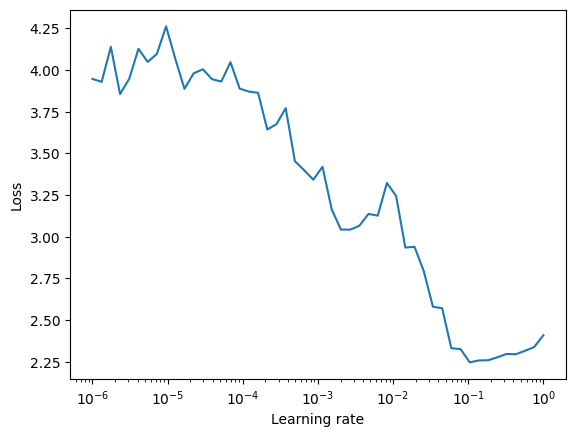

In [38]:
batches_per_epoch = 50
lr_list = np.logspace(-6,0,batches_per_epoch) # Your code goes here
print(lr_list)

# Run
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xscale('log') # Use log scale on x-axis
plt.xlabel('Learning rate');
plt.ylabel('Loss');

**Comments: What to look for?**
The numerical value of the loss is not important. What is important is the rate of change of the loss. So what we are looking for is the range of learning rates, where the loss decreases most rapidly. That seems to be somewhere between 10^-2 and 10^-1 (look for steepest slope).

**Additional sub-task:** Can you come up with a simple way to implement Cyclic Learning Rate (CLR) based on the above?

Hint: Run training multiple times using a carefully selected list of learning rates each time.

#### 4.2.2 My solution
Train 4 cycles, and in each cycle use 50 learning rates from 10^-2 to 10^-1.

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 2.0730553 val loss 2.2234433 val accuracy 0.18780048
t 20 lr 0.04291934260128778 train loss 1.953862 val loss 2.059845 val accuracy 0.27313703
t 30 lr 0.02682695795279726 train loss 1.8908156 val loss 1.9240947 val accuracy 0.3266226
t 40 lr 0.016768329368110083 train loss 1.7933884 val loss 1.860839 val accuracy 0.33323318
t 50 lr 0.010481131341546858 train loss 1.895736 val loss 1.8232337 val accuracy 0.34975964
[array(2.3420734, dtype=float32), array(2.2234433, dtype=float32), array(2.059845, dtype=float32), array(1.9240947, dtype=float32), array(1.860839, dtype=float32), array(1.8232337, dtype=float32)]


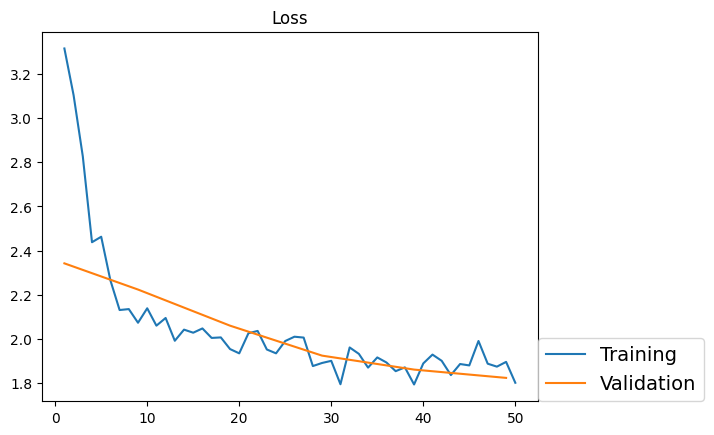

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.813077 val loss 1.8372989 val accuracy 0.32932693
t 20 lr 0.04291934260128778 train loss 1.7608751 val loss 1.7624121 val accuracy 0.367488
t 30 lr 0.02682695795279726 train loss 1.8643163 val loss 1.7419373 val accuracy 0.359375
t 40 lr 0.016768329368110083 train loss 1.7115229 val loss 1.7094839 val accuracy 0.37590146
t 50 lr 0.010481131341546858 train loss 1.767415 val loss 1.6939578 val accuracy 0.38221157
[array(1.82307, dtype=float32), array(1.8372989, dtype=float32), array(1.7624121, dtype=float32), array(1.7419373, dtype=float32), array(1.7094839, dtype=float32), array(1.6939578, dtype=float32)]


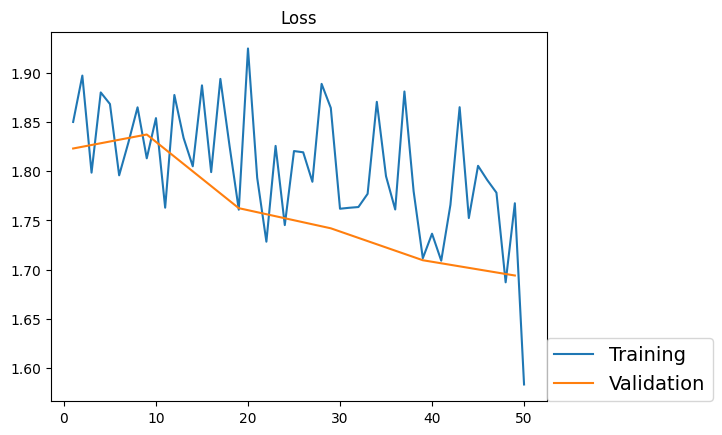

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.694841 val loss 1.7019236 val accuracy 0.3891226
t 20 lr 0.04291934260128778 train loss 1.8019626 val loss 1.6884516 val accuracy 0.38431492
t 30 lr 0.02682695795279726 train loss 1.6475837 val loss 1.6447257 val accuracy 0.39963943
t 40 lr 0.016768329368110083 train loss 1.6436001 val loss 1.6261809 val accuracy 0.40114185
t 50 lr 0.010481131341546858 train loss 1.7350692 val loss 1.612906 val accuracy 0.40745193
[array(1.6952106, dtype=float32), array(1.7019236, dtype=float32), array(1.6884516, dtype=float32), array(1.6447257, dtype=float32), array(1.6261809, dtype=float32), array(1.612906, dtype=float32)]


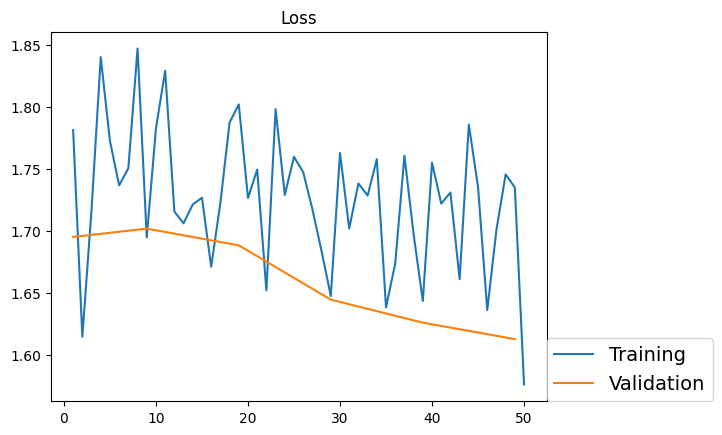

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.7671092 val loss 1.6014581 val accuracy 0.4221755
t 20 lr 0.04291934260128778 train loss 1.7280308 val loss 1.5831913 val accuracy 0.4185697
t 30 lr 0.02682695795279726 train loss 1.7185926 val loss 1.5673743 val accuracy 0.43359378
t 40 lr 0.016768329368110083 train loss 1.678283 val loss 1.5483184 val accuracy 0.43569714
t 50 lr 0.010481131341546858 train loss 1.6242659 val loss 1.5382042 val accuracy 0.43990386
[array(1.6107707, dtype=float32), array(1.6014581, dtype=float32), array(1.5831913, dtype=float32), array(1.5673743, dtype=float32), array(1.5483184, dtype=float32), array(1.5382042, dtype=float32)]


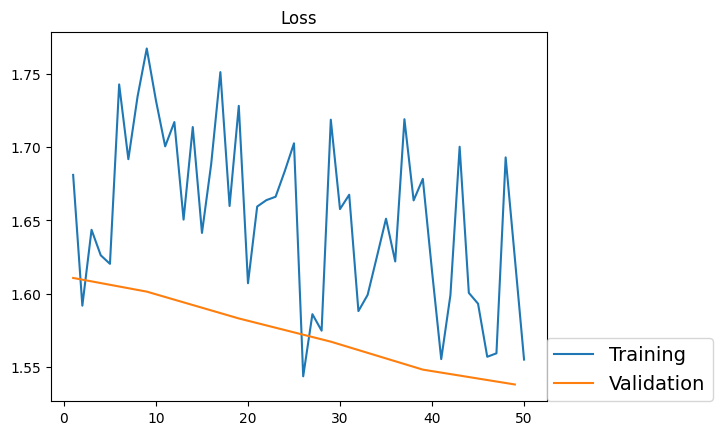

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.5992098 val loss 1.5707624 val accuracy 0.42007214
t 20 lr 0.04291934260128778 train loss 1.6165267 val loss 1.5841744 val accuracy 0.42097357
t 30 lr 0.02682695795279726 train loss 1.6353393 val loss 1.543331 val accuracy 0.44290867
t 40 lr 0.016768329368110083 train loss 1.6146374 val loss 1.5223603 val accuracy 0.44471157
t 50 lr 0.010481131341546858 train loss 1.746203 val loss 1.5077016 val accuracy 0.45612982
[array(1.5351635, dtype=float32), array(1.5707624, dtype=float32), array(1.5841744, dtype=float32), array(1.543331, dtype=float32), array(1.5223603, dtype=float32), array(1.5077016, dtype=float32)]


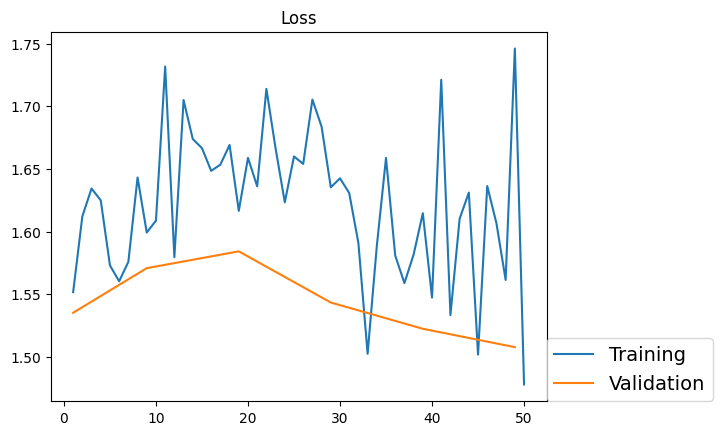

In [39]:
lr_list = np.logspace(-2,-1,50) # Learning rates in ascending order
lr_list = np.flip(lr_list,axis=0) # Learning rates in descending order
batches_per_epoch = len(lr_list)
epochs = 1

def CLR(t,T,lr):
  return lr_list[t-1]

reset_parameters(model)
for cycle in range(5):
  train_loss_history = fit(model,lr_scheduler=CLR,epochs=epochs,batches_per_epoch=batches_per_epoch)

### 4.3 Experiment with dropout
Below is a slight modification of our model that allows changing the dropout fraction (p).

**Your task** is to experiment with different values of p.

- What does setting p = 0 mean?
- Try different values of p (say 0, 0.1, 0.5 and 0.9). What is the optimal value of p?

In [40]:
def Net(p=0.5):
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=p),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

# Model with p=0.25
model = Net(p=0.25).cuda()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.7063913 val loss 2.479138 val accuracy 0.1234375
t 20 lr 0.001 train loss 2.3184812 val loss 2.351408 val accuracy 0.1578125
t 30 lr 0.001 train loss 2.308418 val loss 2.259165 val accuracy 0.18593751
t 40 lr 0.001 train loss 2.1648855 val loss 2.1915166 val accuracy 0.20625
t 50 lr 0.001 train loss 2.1491413 val loss 2.1456773 val accuracy 0.21718751
t 60 lr 0.001 train loss 2.0283153 val loss 2.105954 val accuracy 0.2359375
t 70 lr 0.001 train loss 2.0677536 val loss 2.0751362 val accuracy 0.24375
t 80 lr 0.001 train loss 1.9712696 val loss 2.04905 val accuracy 0.25625
t 90 lr 0.001 train loss 1.9587705 val loss 2.0275075 val accuracy 0.2609375
t 100 lr 0.001 train loss 1.9682717 val loss 2.0073698 val accuracy 0.2640625
[array(2.6174304, dtype=float32), array(2.479138, dtype=float32), array(2.351408, dtype=float32), array(2.259165, dtype=float32), array(2.1915166, dtype=float32), array(2.1456773, 

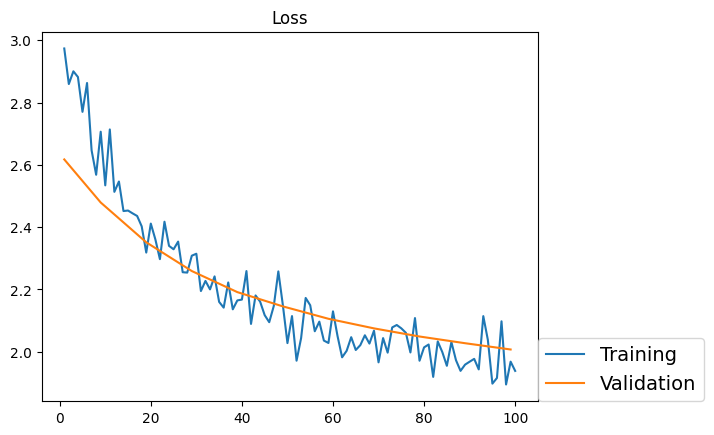

In [41]:
# p = 0 means no dropout
model = Net(p=0.0).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 5.7013187 val loss 2.4890049 val accuracy 0.1328125
t 20 lr 0.001 train loss 4.9638305 val loss 2.5612423 val accuracy 0.165625
t 30 lr 0.001 train loss 4.2769165 val loss 2.48261 val accuracy 0.120312504
t 40 lr 0.001 train loss 3.6956422 val loss 2.3110256 val accuracy 0.1375
t 50 lr 0.001 train loss 3.2426207 val loss 2.238776 val accuracy 0.1609375
t 60 lr 0.001 train loss 3.5893555 val loss 2.2120504 val accuracy 0.171875
t 70 lr 0.001 train loss 3.2357068 val loss 2.1970825 val accuracy 0.165625
t 80 lr 0.001 train loss 3.0641072 val loss 2.1884909 val accuracy 0.165625
t 90 lr 0.001 train loss 2.9209638 val loss 2.1802766 val accuracy 0.1671875
t 100 lr 0.001 train loss 3.0435493 val loss 2.1738641 val accuracy 0.165625
[array(2.5116587, dtype=float32), array(2.4890049, dtype=float32), array(2.5612423, dtype=float32), array(2.48261, dtype=float32), array(2.3110256, dtype=float32), array(2.238776

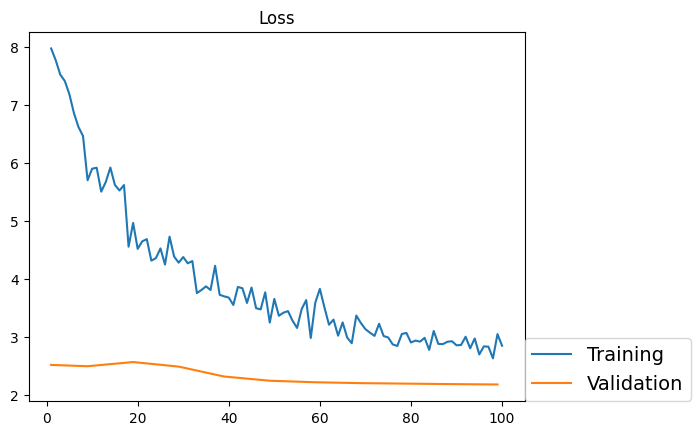

In [42]:
# p = 0.9 means "heavy dropout", which is in general a bad idea
model = Net(p=0.9).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.6527963 val loss 2.4830723 val accuracy 0.1171875
t 20 lr 0.001 train loss 2.5441134 val loss 2.456867 val accuracy 0.1015625
t 30 lr 0.001 train loss 2.4540162 val loss 2.3880048 val accuracy 0.1328125
t 40 lr 0.001 train loss 2.2423244 val loss 2.2994165 val accuracy 0.1671875
t 50 lr 0.001 train loss 2.142974 val loss 2.2381132 val accuracy 0.19375001
t 60 lr 0.001 train loss 2.2023554 val loss 2.187692 val accuracy 0.2046875
t 70 lr 0.001 train loss 2.1368582 val loss 2.1449733 val accuracy 0.228125
t 80 lr 0.001 train loss 2.0132477 val loss 2.1048052 val accuracy 0.2359375
t 90 lr 0.001 train loss 2.1301248 val loss 2.0697105 val accuracy 0.246875
t 100 lr 0.001 train loss 1.9843519 val loss 2.0399702 val accuracy 0.2609375
[array(2.655867, dtype=float32), array(2.4830723, dtype=float32), array(2.456867, dtype=float32), array(2.3880048, dtype=float32), array(2.2994165, dtype=float32), array(2.2

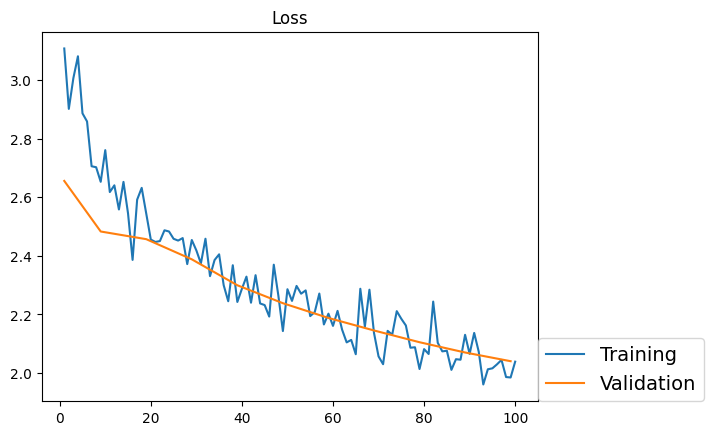

In [43]:
# p = 0.1
model = Net(p=0.1).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

### 4.4 Data augmentation
Adding more training data is the best way to improve your models abiliy to generalize to unseen data. Data augmentations is basically about generating additional *fake data" to expand the size of your training set.

**Your task** is to experiment with different types of data augmentation. All you have to do is change the transformer below and add some of the available transforms: https://pytorch.org/vision/stable/transforms.html

You can find inspiration in `Lab5_PyTorch_TransferLearning.ipynb`: https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2025/blob/main/Lab5_PyTorch_TransferLearning.ipynb


images.shape torch.Size([64, 3, 32, 32])


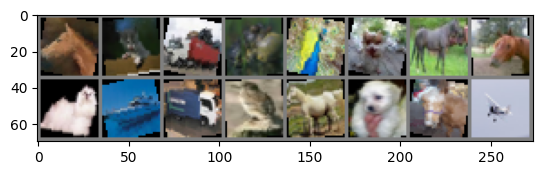

horse   cat truck  frog  bird   dog horse horse   dog  ship truck  bird horse   dog horse plane


In [44]:
mean = 0.5
std = 0.5
transform = transforms.Compose(
    [ # My solution
      transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability.
      transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
      transforms.RandomRotation(degrees=15), # Rotate the image by angle.
      transforms.ToTensor(),
      transforms.Normalize((mean, mean, mean), (std, std, std))
     ])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('images.shape',images.shape)

# show 10 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.20631 val loss 2.6262634 val accuracy 0.1328125
t 20 lr 0.001 train loss 2.8924174 val loss 2.4140756 val accuracy 0.159375
t 30 lr 0.001 train loss 2.8426714 val loss 2.3959577 val accuracy 0.1578125
t 40 lr 0.001 train loss 2.6394978 val loss 2.294689 val accuracy 0.1640625
t 50 lr 0.001 train loss 2.4087038 val loss 2.2288857 val accuracy 0.2125
t 60 lr 0.001 train loss 2.4701 val loss 2.2040558 val accuracy 0.1984375
t 70 lr 0.001 train loss 2.5730758 val loss 2.1726015 val accuracy 0.228125
t 80 lr 0.001 train loss 2.447453 val loss 2.1284199 val accuracy 0.2296875
t 90 lr 0.001 train loss 2.4241595 val loss 2.110693 val accuracy 0.2453125
t 100 lr 0.001 train loss 2.3210056 val loss 2.0831687 val accuracy 0.25468752
[array(3.2441838, dtype=float32), array(2.6262634, dtype=float32), array(2.4140756, dtype=float32), array(2.3959577, dtype=float32), array(2.294689, dtype=float32), array(2.2288857,

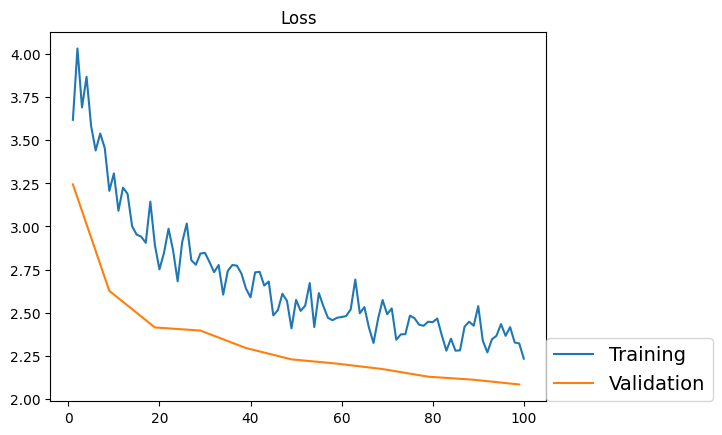

In [45]:
# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

### 4.5 Multi-task learning (MTL)
By sharing representations between related tasks, we can enable our model to generalize better on our original task. This is the basic idea behind MTL.

There is one additional task that we can always add, and that is an **autoencoder**. Recall that an autoencoder is basically an identity function that maps input x to itself. It does so by first encoding x into a more compact representation E(x), and then decodes this representation to get a reconstruction of x = D(E(x)), where E() is the encoder, and D() is the decoder.

The network below uses the **same encoder** to solve both a **classification task** and an **autoencoder task**.

In [46]:
# define the NN architecture
class MTLNet(nn.Module):
    def __init__(self):
        super(MTLNet, self).__init__()

        ## shared encoder layers ##
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 4, 5, stride=2, padding=2)

        ## decoder layers ##
        # Classifier
        self.fc1 = nn.Linear(in_features=4*8*8, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

        ## Autoencoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # decoder for task 1 - outputs scores for classifier
        scores = x.view(-1, 4*8*8)
        scores = F.relu(self.fc1(scores))
        scores = self.fc2(scores)

        ## decoder for task 2 - outputs reconstruction of input x
        recon = F.relu(self.t_conv1(x))
        recon = self.t_conv2(recon)

        return scores, recon

# initialize the NN
model = MTLNet()

Let's look at the output of this model:

scores.shape torch.Size([64, 10])
recon.shape torch.Size([64, 3, 32, 32])

Input images:



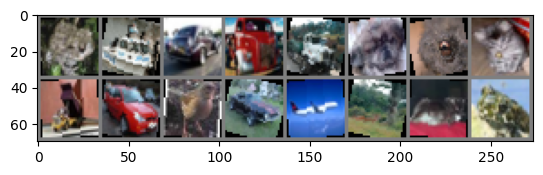

Reconstructed images:



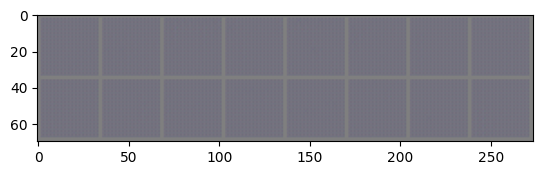

In [47]:
# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

scores,recon = model(images)
print('scores.shape',scores.shape)
print('recon.shape',recon.shape)

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))

In order to optimize our MTL model we need a loss function. However, since we are solving two tasks, we also need two terms in our loss function - one for each task.

The loss for the classification task is the familiar cross entropy:

In [48]:
# Classification loss
loss_func_1 = F.cross_entropy
loss1 = loss_func_1(scores, labels)
print('Loss 1', loss1)

Loss 1 tensor(2.3100, grad_fn=<NllLossBackward0>)


A suitable loss for the autoencoder task would be the Mean Squared Error (MSE) between the input images (say `images`) and the networks reonstruction (say `recon`):

In [49]:
# MSE loss for reconstruction
loss_func_2 = F.mse_loss
loss2 = loss_func_2(images,recon)
print('Loss 2', loss2)

Loss 2 tensor(0.2848, grad_fn=<MseLossBackward0>)


Below is a modified function to fit the MTL model.

**Your task** is simply to fill in the missing code (marked with ???).

This is not as trivial as you might think (hint: do the two losses have the same scale?).

In [50]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  loss1_history = []
  loss2_history = []
  plot_time_train = []

  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = loss_func_2(recon, xb.cuda())

      loss = loss1 + loss2

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
loss1 2.282282 loss2 0.3044052
loss1 2.2653055 loss2 0.27418864
loss1 2.1558454 loss2 0.30506885
loss1 2.2064013 loss2 0.28313836
loss1 2.1662076 loss2 0.28057298
loss1 2.116462 loss2 0.27335557
loss1 2.0787802 loss2 0.2713694
loss1 2.1037128 loss2 0.2846471
loss1 2.0554461 loss2 0.286043
loss1 2.0496585 loss2 0.2833055


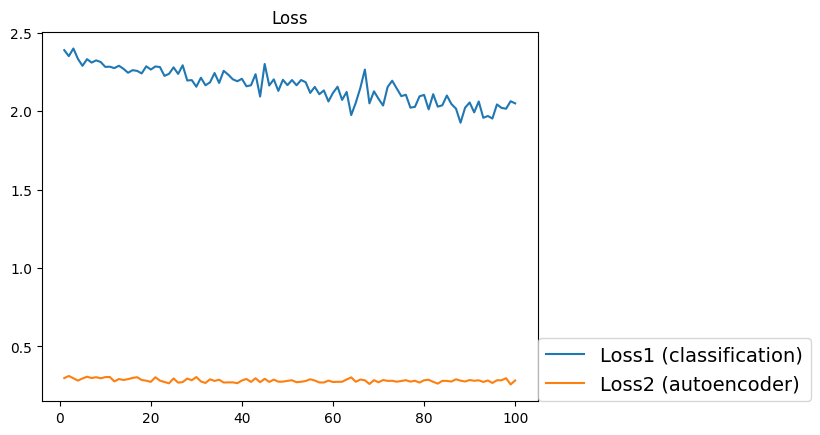

In [51]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

**Comments:**
- Here I set loss = loss1 + loss2, but clearly loss1 is much higher than loss2.
- To balance them out we could set loss = loss1 + 10*loss2:

In [52]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  loss1_history = []
  loss2_history = []
  plot_time_train = []

  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = 10 * loss_func_2(recon, xb.cuda())

      loss = loss1 + loss2

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
loss1 2.2926996 loss2 3.0630436
loss1 2.1906962 loss2 2.7834702
loss1 2.2108521 loss2 2.5831795
loss1 1.9669142 loss2 2.3963878
loss1 2.0079606 loss2 1.783304
loss1 2.0438056 loss2 1.5739193
loss1 1.974546 loss2 1.3217018
loss1 1.9557259 loss2 1.1542727
loss1 2.0754302 loss2 1.0458623
loss1 2.0390038 loss2 1.115444


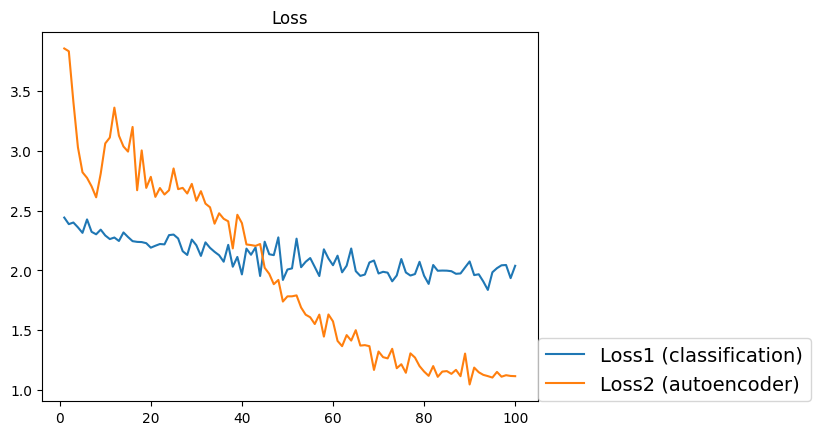

In [53]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

**Comment:** Looks better! Now, train for more epochs.

Epochs: 50 Batches per epoch: 20 Total number of batches 1000
loss1 1.918509 loss2 1.055042
loss1 2.005807 loss2 1.157815
loss1 2.0571098 loss2 1.1019509
loss1 2.027679 loss2 1.0619563
loss1 1.917675 loss2 0.96995825
loss1 1.8598542 loss2 1.0113202
loss1 1.9347754 loss2 1.0596849
loss1 1.7848182 loss2 1.0171769
loss1 1.9385543 loss2 0.9773654
loss1 1.8232728 loss2 1.0227485
loss1 1.9363018 loss2 0.99360096
loss1 1.7711738 loss2 1.0840696
loss1 1.6449019 loss2 0.99087
loss1 1.8316642 loss2 0.98774254
loss1 1.8220918 loss2 0.9853016
loss1 1.6958523 loss2 0.9186426
loss1 1.7959759 loss2 0.86634743
loss1 1.5184646 loss2 0.8973857
loss1 1.7460012 loss2 0.83725023
loss1 1.7890341 loss2 0.84031093
loss1 1.5707114 loss2 0.8327998
loss1 1.5960808 loss2 0.85183394
loss1 1.5941098 loss2 0.75600195
loss1 1.6991994 loss2 0.73199415
loss1 1.8012516 loss2 0.7796303
loss1 1.5543811 loss2 0.7634842
loss1 1.6231344 loss2 0.7820244
loss1 1.7112668 loss2 0.766294
loss1 1.425859 loss2 0.75243735
loss1 1.59

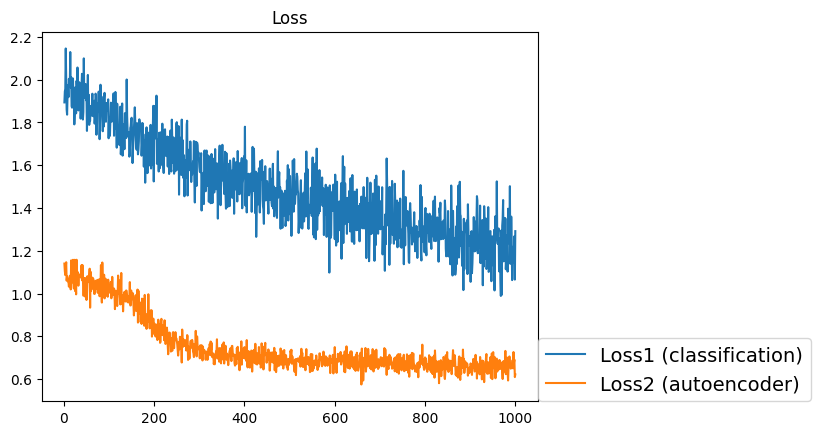

In [54]:
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=50,batches_per_epoch=20)

We should probably train for longer, but let's evaluate:

accuracy tensor(0.4244, device='cuda:0')

Input images:



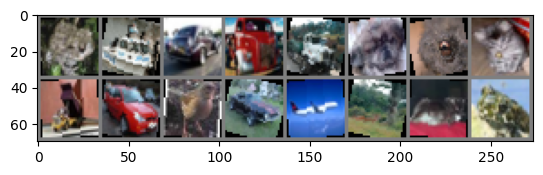

Reconstructed images:



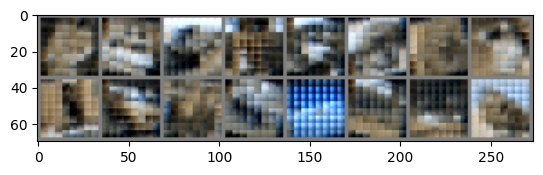

In [55]:
scores,recon = model(images.cuda())

# validation accuracy
acc = 0
for xb, yb in testloader:
  scores,recon_dummy = model(xb.cuda())
  acc += accuracy(scores,yb.cuda())
print('accuracy',acc/len(testloader))

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))